This block read data from a demo session. Mouse #27049, 20220516, session 1

In [1]:
import numpy as np
import os
import pandas as pd
import pickle
import time
import copy as cp

from mazepy.datastruc.variables import VariableBin
from mazepy.datastruc.neuact import KilosortSpikeTrain, NeuralTrajectory, SpikeTrain
from replay.preprocess.read import read_npxdata 
from replay.preprocess.behav import transform_time_format

from replay.local_path import f1_behav as f
from preprocess.neuact_main import get_within_trial_spike_index

i = 0
# Read behavior data
with open(f['Trace Behav File'][i], 'rb') as handle:
    trace = pickle.load(handle)

trace.update(read_npxdata(f['npx_folder'][i]))

In [16]:
print(type(f['npx_init_time'][i]), type(f['behav_init_time'][i]))
npx_init_time = transform_time_format(f['npx_init_time'][i])[0]
behav_init_time = transform_time_format(f['behav_init_time'][i])[0]
behav_time = trace['video_time'] - npx_init_time + behav_init_time
    
within_trial_spike_index = get_within_trial_spike_index(
    trace['spike_times'],
    behav_time[trace['onset_frames']],
    behav_time[trace['end_frames']]
)


spikes_remain = trace['spike_clusters'][within_trial_spike_index]
spike_time_remain = trace['spike_times'][within_trial_spike_index]
frequency = trace['dominant_freq_filtered'][trace['dominant_freq_filtered'] > 0]

from mazepy.basic.convert import coordinate_recording_time

t2 = time.time()
idx = coordinate_recording_time(
    spike_time_remain, 
    behav_time
)
spike_freq = trace['dominant_freq_filtered'][idx] - 23
assert np.where(spike_freq < 0)[0].shape[0] == 0
spike_freq = spike_freq // 2

t1 = time.time()
assert spike_time_remain.shape[0] == spike_freq.shape[0]
spike_train = KilosortSpikeTrain.get_spike_train(
    activity=spikes_remain,
    time=spike_time_remain * 1000, # Convert to ms
    variable=VariableBin(spike_freq)
)
print(time.time() - t1)

<class 'str'> <class 'str'>
2.529120445251465


In [18]:
from mazepy.basic._cshuffle import _shift_shuffle_kilosort, _shift_shuffle

res = _shift_shuffle(
    spikes = spike_train.astype(np.int64),
    dtime = spike_train.get_dt().astype(np.float64),
    variable = spike_freq.astype(np.int64),
    nbins = 76,
    n_shuffle = 1000,
    info_thre = 95
)
"""
res = _shift_shuffle_kilosort(
    spikes = spikes_remain.astype(np.int64),
    dtime = spike_train.get_dt().astype(np.float64),
    variable = spike_freq.astype(np.int64),
    nbins = 76,
    n_shuffle = 1000
)
"""
print(res.shape)
print(np.sum(res[:, 0]))

C:\Users\YSY\AppData\Local\Temp\ipykernel_38012\3389347544.py:3: RuntimeWarning: invalid value encountered in divide
  res = _shift_shuffle(


(644, 3)
69.0


In [19]:
plotidx = np.where((res[:, 1] > 1)&(res[:, 0] == 1))[0]
trace['brain_region'][plotidx]

array(['PAR', '', '', '', 'MEC', '', 'VIS', '', ''], dtype='<U6')

In [20]:
t1 = time.time()
res1 = spike_train.calc_tuning_curve(
    nbins=76, 
    kilosort_spikes=KilosortSpikeTrain(
        activity=spikes_remain,
        time=spike_time_remain * 1000, # Convert to ms
        variable=VariableBin(spike_freq)
    )
)
t2 = time.time()

from mazepy.datastruc.kernel import GaussianKernel1d
kernel = GaussianKernel1d(n = 76, sigma=0.8)
res2 = res1.smooth(kernel)

t3 = time.time()
print(t2 - t1)
print(t3 - t2)
print(np.where(res1-res2 > 0.00001))

print(type(spike_train.astype(np.int64)))
spike_train.to_array()

0.01699995994567871
0.002000093460083008
(array([  0,   0,   0, ..., 643, 643, 643], dtype=int64), array([ 0,  2,  4, ..., 53, 57, 70], dtype=int64))
<class 'mazepy.datastruc.neuact.SpikeTrain'>


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

1.3896129030166153 1.3104521244303955


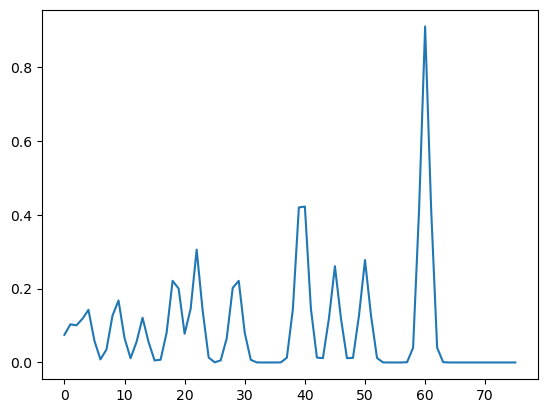

1.9922460820417622 1.96466061971572


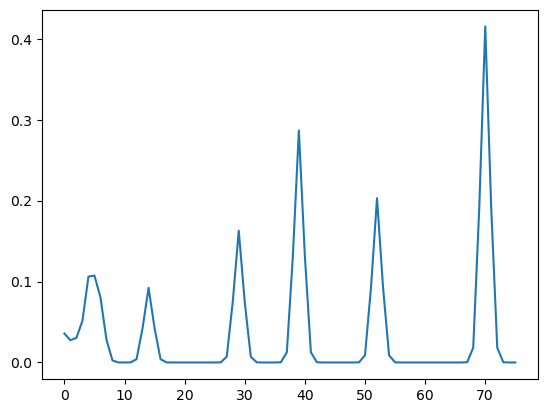

1.6127711149316293 1.612645253950248


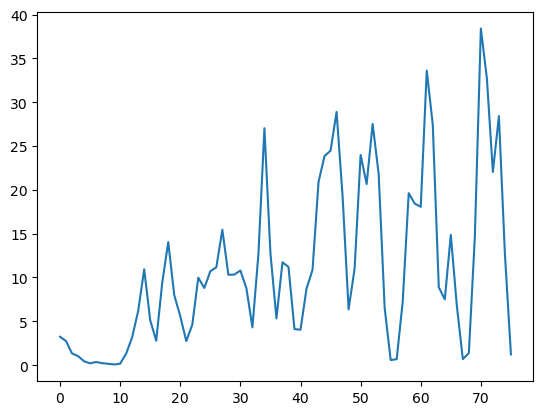

1.358436646230031 1.3540019455359475


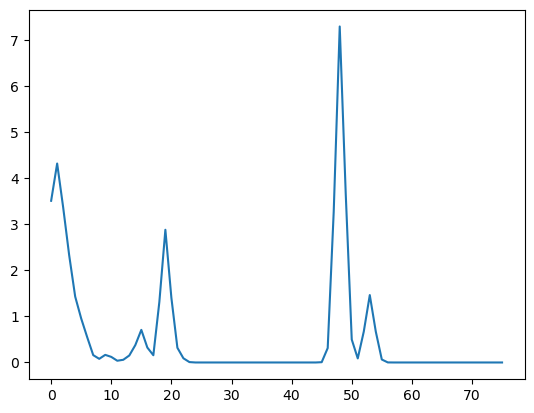

1.5377339152687388 1.4730258736818034


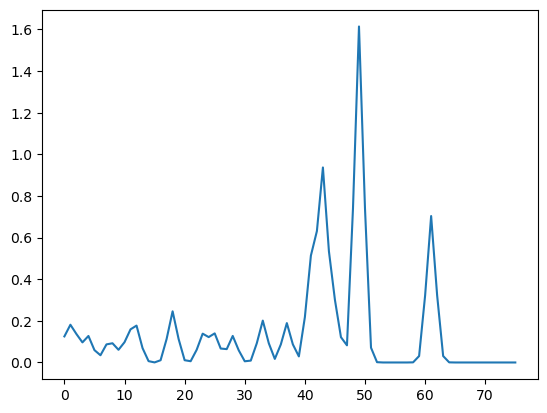

1.0100219687931673 0.9743613794177078


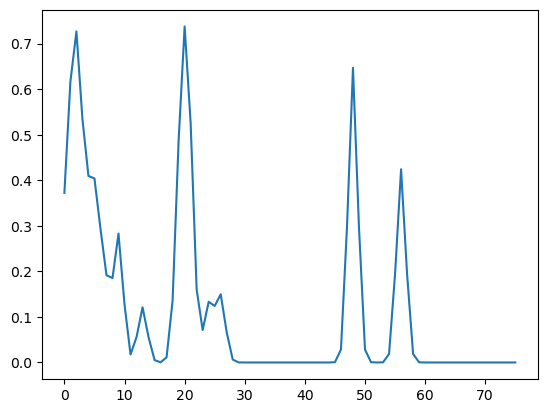

2.5425923896606513 2.464266817143788


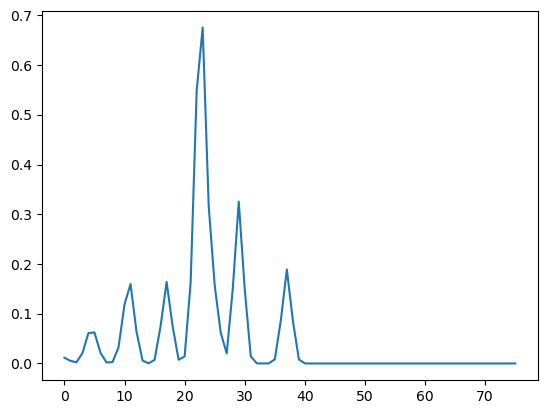

2.443847846773662 2.4267492166157663


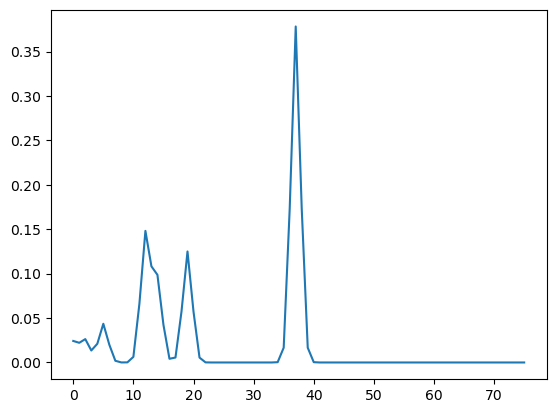

2.647945168968638 2.6379856771229897


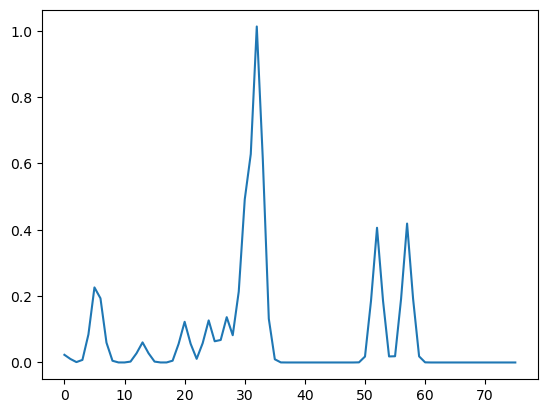

In [21]:
import matplotlib.pyplot as plt
res2[:, np.isnan(res2.occu_time)] = np.nan
for t in plotidx:
    print(res[t, 1], res[t, 2])
    plt.plot(np.arange(res2.shape[1]), res2[t, :])
    plt.show()

In [ ]:
neural_traj = spike_train.calc_neural_trajectory(t_window=200, step_size=25)

(71498,)
0.6524715423583984
0.05601763725280762


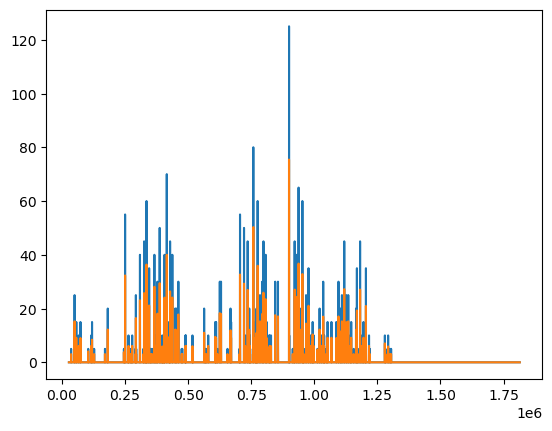

In [ ]:
import matplotlib.pyplot as plt

print(neural_traj.time.shape)
plt.plot(neural_traj.time, neural_traj[5, :])

from mazepy.datastruc.kernel import GaussianKernel1d
kernel = GaussianKernel1d(n = 20, sigma=5)
t1 = time.time()
smoothed_traj = neural_traj.smooth(kernel)
print(time.time() - t1)
plt.plot(neural_traj.time, smoothed_traj[5, :])

t1 = time.time()
clipped_traj = neural_traj.clip_within_trials(
    behav_time[trace['onset_frames']] * 1000,
    behav_time[trace['end_frames']] * 1000
)
print(time.time() - t1)
